In [1]:
import pandas as pd

In [87]:
import json
with open("q1_data.json", "r") as file:
    data = json.load(file)

df = pd.json_normalize(data, record_path=['user',[]], meta=['session_id', 'unix_timestamp', 'cities'])

In [88]:
df.isna().sum()

user_id              0
joining_date         0
country              0
_row              5777
session_id           0
unix_timestamp       0
cities               0
dtype: int64

Converting time into hours and minutes, this will help us to identify the timezone

In [89]:
df['datetime_normal'] = pd.to_datetime(df['unix_timestamp'], unit='s')

In [90]:
df.head()

,user_id,joining_date,country,_row,session_id,unix_timestamp,cities,datetime_normal
0,2024,2015-03-22,UK,NaN,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2015-09-17 15:28:28
1,2853,2015-03-28,DE,NaN,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31
2,10958,2015-03-06,UK,NaN,SHTB4IYAX4PX6,1440843490,San Antonio TX,2015-08-29 10:18:10
3,7693,2015-03-12,IT,NaN,JBRB8MZGTX3M4,1427268063,Edmonton AB,2015-03-25 07:21:03
4,7506,2015-02-28,UK,NaN,YJCMPURC2FL9C,1430559067,"Phoenix AZ, Houston TX",2015-05-02 09:31:07


Lets see how many countries are there

In [91]:
df.country.unique()

array(['UK', 'DE', 'IT', 'ES', '', 'US', 'FR'], dtype=object)

This tells us the country we are looking at has a good number of user on our platform

In [92]:
df.groupby('country',as_index=False)['user_id'].nunique()

,country,user_id
0,,792
1,DE,1051
2,ES,569
3,FR,665
4,IT,528
5,UK,1043
6,US,1129


Lets analyse only the hour of surfing

In [93]:
df['hour_at_surfing'] = df.datetime_normal.dt.hour

In [94]:
import seaborn as sns

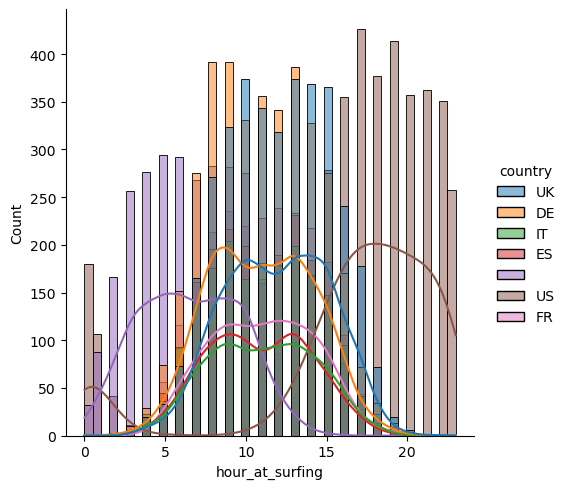

In [95]:
sns.displot(data=df, x='hour_at_surfing', hue='country', kde=True)

This graph shows us almost every country is having normal distribution, this is good news for us as we can be sure of timezone of the missing country

In [96]:
df.groupby('country').agg({'hour_at_surfing':['mean', 'median', 'min', 'max']})

hour_at_surfing               
                   mean median min max
country                               
               6.580142    7.0   0  16
DE            10.987356   11.0   2  20
ES            10.837686   11.0   3  21
FR            11.037424   11.0   2  20
IT            11.007970   11.0   2  19
UK            11.959212   12.0   3  22
US            16.784830   18.0   0  23

This time/hour is based on UTC, hence this shows time based on GMT, using which we can narrow down our search to those contries of the world. We can assume from the data that we always get the median value during 12 PM as per local time. With this assumption

If we see the timings here:
    
DE -> Germany -> +1 hour to GMT -> 11 AM UTC -> 12 PM in Germany
    
ES -> Spain -> +1 hour to GMT -> 11 AM UTC -> 12 PM in Spain
    
FR -> France -> +1 hour to GMT -> 11 AM UTC -> 12 PM in France
    
IT -> Italy -> +1 hour to GMT -> 11 AM UTC -> 12 PM in Italy
    
UK -> United Kingdom -> 0 hour to GMT -> 12 PM UTC -> 12 PM in United Kingdom
    
US -> United States -> -5 hour to GMT -> 18 AM UTC -> 1 PM in United States
    
"" -> UNKNOWN -> +5 hour to GMT -> 7 AM UTC -> 12 PM in **`[Kazakhstan, Maldives, Pakistan, Tajikistan, Turkmenistan, Uzbekistan]`**
    

### Part 1 -> Missing country could be any of the following

**`[Kazakhstan, Maldives, Pakistan, Tajikistan, Turkmenistan, Uzbekistan]`**

Lets look at the city frequency

In [97]:
import itertools

def get_city_pairs(city_string):
    cities = city_string.split(', ')
    return list(itertools.combinations(cities, 2))

df['city_pairs'] = df['cities'].apply(get_city_pairs)
df_exploded = df.explode('city_pairs')
freq = df_exploded.groupby('city_pairs').size().reset_index(name='freq')
freq = freq[freq['freq'] > 1].sort_values('freq', ascending=False)

### Part 2 -> Most likely searched city, in pair [when order of search doesn't matter]

In [98]:
freq

,city_pairs,freq
487,"(New York NY, Jersey City NJ)",537
490,"(New York NY, Newark NJ)",419
494,"(New York NY, Philadelphia PA)",321
737,"(Toronto ON, Saint Catharines-Niagara ON)",258
736,"(Toronto ON, Oshawa ON)",254
...,...,...
536,"(Oakland CA, Fresno CA)",2
259,"(Halifax NS, Boston MA)",2
87,"(Chandler AZ, Glendale AZ)",2
544,"(Oklahoma City OK, Plano TX)",2


In [122]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="cal_geo_dist")

def get_distance(city_pair):
    if isinstance(city_pair, (list, tuple)):
        city1 = city_pair[0]
        city2 = city_pair[1]
        try:
            location1 = geolocator.geocode(city1)
            location2 = geolocator.geocode(city2)
            distance = geodesic((location1.latitude, location1.longitude), (location2.latitude, location2.longitude)).miles
        except:
            distance = None
    else:
        distance = None
    return distance

df_exploded['distance'] = df_exploded['city_pairs'].apply(get_distance)


In [132]:
df_exploded

,user_id,joining_date,country,_row,session_id,unix_timestamp,cities,datetime_normal,hour_at_surfing,city_pairs,distance
0,2024,2015-03-22,UK,NaN,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2015-09-17 15:28:28,15,"(New York NY, Newark NJ)",8.875033
1,2853,2015-03-28,DE,NaN,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31,8,"(New York NY, Jersey City NJ)",2.259566
1,2853,2015-03-28,DE,NaN,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31,8,"(New York NY, Philadelphia PA)",80.530832
1,2853,2015-03-28,DE,NaN,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2015-09-04 08:06:31,8,"(Jersey City NJ, Philadelphia PA)",79.287032
2,10958,2015-03-06,UK,NaN,SHTB4IYAX4PX6,1440843490,San Antonio TX,2015-08-29 10:18:10,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20017,4360,2015-03-21,,4235.4,17WJGZOEFEI4W,1430545204,"Chicago IL, Montreal QC",2015-05-02 05:40:04,5,"(Chicago IL, Montreal QC)",746.099253
20018,2057,2015-03-22,IT,3341.3,9HCZDQMGU5Z2G,1434444360,Chicago IL,2015-06-16 08:46:00,8,NaN,NaN
20019,1203,2015-02-28,IT,2001.6,73ZWORX75Y9A0,1438584470,Chicago IL,2015-08-03 06:47:50,6,NaN,NaN
20020,3699,2015-03-24,ES,2473.5,DMWGV9HY74G9T,1435235491,"Calgary AB, New York NY",2015-06-25 12:31:31,12,"(Calgary AB, New York NY)",2030.151846


In [124]:
df_exploded[(df_exploded.city_pairs.isna()) & (~df_exploded.distance.isna())]

,user_id,joining_date,country,_row,session_id,unix_timestamp,cities,datetime_normal,hour_at_surfing,city_pairs,distance


<AxesSubplot: xlabel='distance', ylabel='Count'>

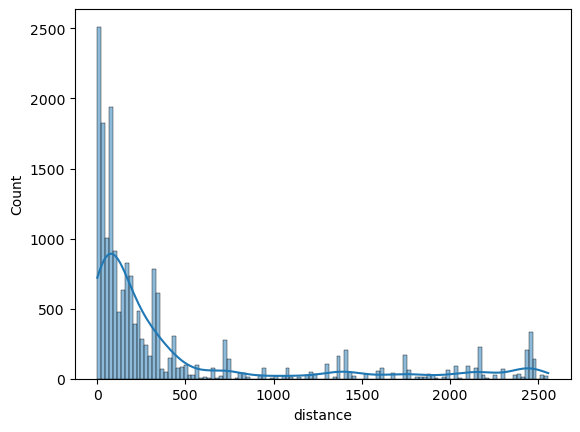

In [153]:
t = df_exploded.reset_index(drop=True)
sns.histplot(data=t, x='distance', kde=True)

In [184]:
df_dist_session = df_exploded.groupby(['session_id', 'country'], as_index=False).agg({'distance':'mean', 'city_pairs':'count'})
df_dist_session

,session_id,country,distance,city_pairs
0,0004TZ56GY6S7,DE,2432.915569,1
1,004M08GLQ7ZXH,US,NaN,0
2,007O320DQ7AXT,,NaN,0
3,007UIISVZJOW5,DE,NaN,0
4,008ZL2D1PLC4O,US,712.548448,1
...,...,...,...,...
20017,ZZS8OMNGVGEGV,DE,NaN,0
20018,ZZV3W3ZE2R0W8,,NaN,0
20019,ZZWVLD5228M5Z,IT,NaN,0
20020,ZZWX86DF4JBLT,ES,31.010842,1


In [185]:
df_dist_session.city_pairs[df_dist_session.city_pairs<2] += 1

/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_17883/354294520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_session.city_pairs[df_dist_session.city_pairs<2] += 1


In [186]:
df_exploded.distance.describe()

count    18363.000000
mean       440.744134
std        676.091572
min          1.127851
25%         53.228893
50%        147.225281
75%        348.418752
max       2555.200813
Name: distance, dtype: float64

<AxesSubplot: xlabel='distance', ylabel='Count'>

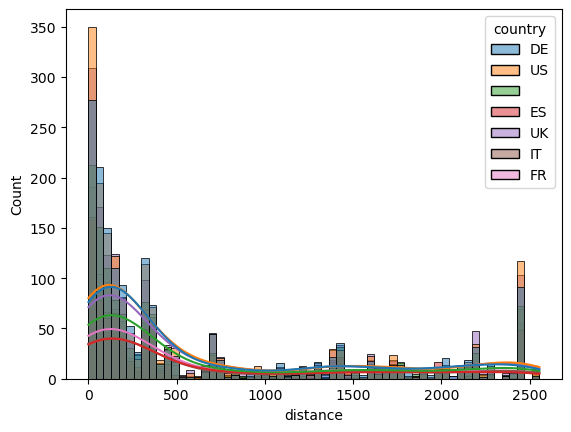

In [187]:
sns.histplot(data=df_dist_session, x='distance', kde=True, bins=60, hue='country')

<AxesSubplot: xlabel='country', ylabel='distance'>

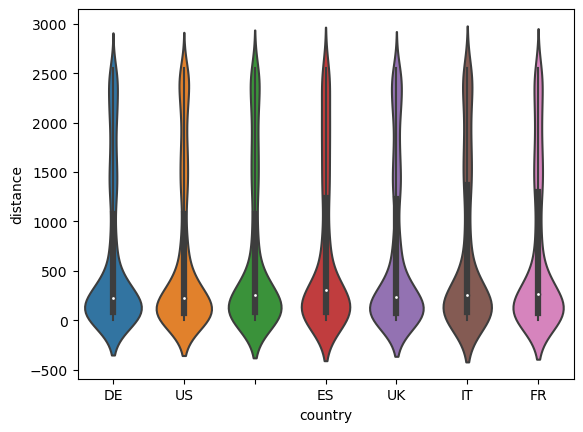

In [188]:
sns.violinplot(data=df_dist_session, x='country', y='distance')

<AxesSubplot: xlabel='city_pairs', ylabel='country'>

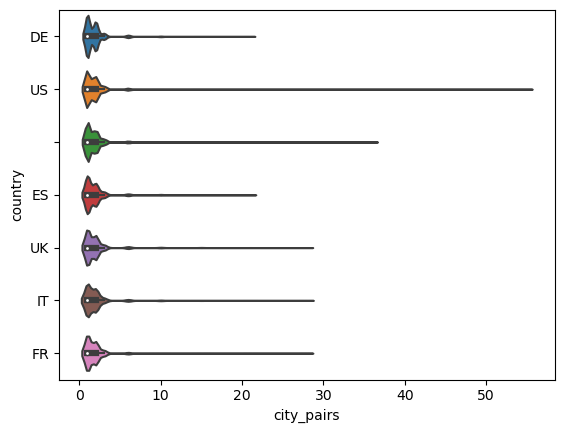

In [189]:
sns.violinplot(data=df_dist_session, y='country', x='city_pairs')

<AxesSubplot: xlabel='city_pairs', ylabel='distance'>

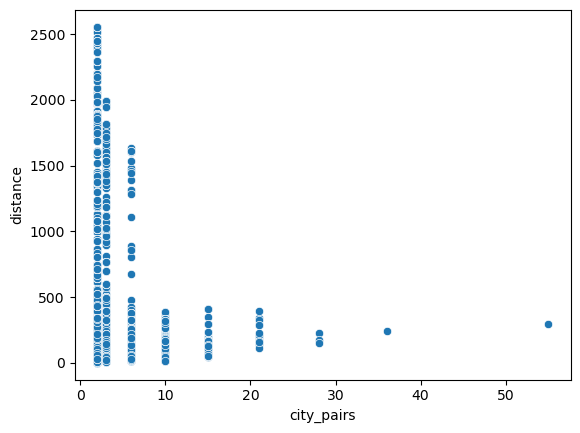

In [190]:
sns.scatterplot(data=df_dist_session, y='distance', x='city_pairs')

In [202]:
df_dist_session.head()

,session_id,country,distance,city_pairs
0,0004TZ56GY6S7,DE,2432.915569,2
1,004M08GLQ7ZXH,US,NaN,1
2,007O320DQ7AXT,,NaN,1
3,007UIISVZJOW5,DE,NaN,1
4,008ZL2D1PLC4O,US,712.548448,2


In [210]:
df_dist_session['distance'].describe(percentiles=[.1, .2, .3, .4, .5, .75])

count    9350.000000
mean      656.647254
std       801.681976
min         1.127851
10%        24.275438
20%        54.029923
30%        98.213827
40%       146.729902
50%       239.438932
75%      1203.501478
max      2555.200813
Name: distance, dtype: float64

In [205]:
df_dist_session.groupby('city_pairs')['distance'].describe(percentiles=[.1, .2, .3, .4, .5, .75])

,count,mean,std,min,10%,20%,30%,40%,50%,75%,max
city_pairs,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6905.0,796.930693,853.910949,1.127851,29.843506,80.530832,122.193615,250.779145,342.529171,1418.884458,2555.200813
3,1619.0,310.949122,503.412193,5.921089,20.132987,35.769966,53.707821,67.546275,113.254267,230.755072,1987.264776
6,566.0,164.131467,231.755132,11.514455,33.452680,42.131482,54.987768,77.552803,117.259171,182.774378,1630.008497
10,178.0,146.657092,92.076454,14.111740,46.834258,53.660930,84.329238,115.577691,140.785393,190.191245,387.686424
15,61.0,159.582131,83.150738,43.444122,53.569602,106.883806,131.396878,140.976676,151.628063,175.176107,413.044318
21,16.0,224.300643,81.841822,111.374608,145.280416,162.165808,164.369681,188.102440,209.759526,287.158158,397.153317
28,3.0,183.679729,38.190126,152.683902,156.549678,160.415453,164.281228,168.147004,172.012779,199.177642,226.342506
36,1.0,242.793469,NaN,242.793469,242.793469,242.793469,242.793469,242.793469,242.793469,242.793469,242.793469


### Part 3 -> User intent classification

When it comes to segregating customers, it's important to consider the intent of the company after the segmentation. For example, if the company plans to run a targeted marketing campaign, the amount they want to spend, and what actions they want these users to take. Therefore, before making any clusters, it's crucial to determine what the next steps are.

1. We should ignore people who are just searching for 1 or 2 city only.
2. People travelling to 3 different cities may be we can consider median distance as the cutoff, who are doing less distance than the cutoff are 'high intent' rest are 'low intent'
3. For people who are searching more than 3 cities and having avg distance between cities comes out to be less than 240 miles [median of whole dataset]

In [219]:
def get_intent(row):
    if (row['city_pairs'] == 3) and (row['distance']<=113):
        row['intent'] = 'High-intent'
        return row
    elif (row['city_pairs'] > 3) and (row['distance']<=240):
        row['intent'] = 'High-intent'
        return row
    else:
        row['intent'] = 'Low-intent'
        return row
    
df_dist_session = df_dist_session.apply(get_intent, axis=1)
df_dist_session.head()

,session_id,country,distance,city_pairs,intent
0,0004TZ56GY6S7,DE,2432.915569,2,Low-intent
1,004M08GLQ7ZXH,US,NaN,1,Low-intent
2,007O320DQ7AXT,,NaN,1,Low-intent
3,007UIISVZJOW5,DE,NaN,1,Low-intent
4,008ZL2D1PLC4O,US,712.548448,2,Low-intent


<AxesSubplot: xlabel='intent', ylabel='count'>

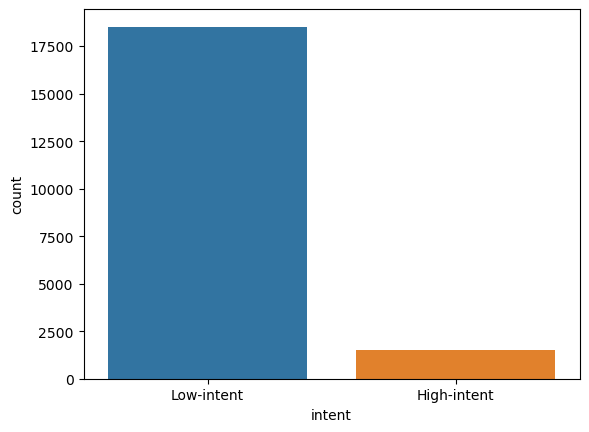

In [220]:
sns.countplot(data=df_dist_session, x='intent')